###Redes neuronales

###Univariante
Objetivo: pronosticar el índice de Precio de la Vivienda Nueva- IPVN para Medellín y su Área Metropolitana, aplicando redes neuronales, pero únicamente sobre la serie univariante sin considerar variables predictoras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Inicialmente, se importan las siguientes librerías:
from google.colab import files
from pathlib import Path
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sklearn
from numpy import mean
from numpy import std
import collections
from sklearn import datasets
import time
import pandas as pnd
import seaborn as sbn

In [ ]:
#Se carga la serie trimestral del índice de precios de la vivienda nueva.
david = '/content/drive/MyDrive/Proyecto Integrador Semestre 2/dataset_vf_deci_coma_indices.xlsx'
su = '/content/drive/MyDrive/MAESTRIA/Semestre2_2020_2/Proyecto Integrador Semestre 2/dataset_vf_deci_coma_indices.xlsx'
ipvn = pd.read_excel(david)

ipvn.head(5)

,ID,Periodo,Año,Trim,d_IPVN_MDE_Num,d_TD_MDE_Porc,d_TO_MDE_Porc,d_PT_MDE_Num_Millon,d_PET_MDE_Num_Millon,d_PEA_MDE_Num_Millon,d_IPC_MDE_Num,d_IPC_NAL_Porc,d_TOSC_NAL_Porc,d_TDSC_NAL_Porc,d_UVAPCSL_Total_NAL_Num,d_PIB_VPCB2015_NAL_Num_Mil_millon,d_PIB_VPCB2015_SC_Num_Mil_Millon,d_TIPPBR_NAL_Porc,d_TIPPST_NAL_Porc,d_OC_MDE_mt2,d_UVAPCSL_Total_ANT_Num,d_UVAPCSL_VIS_ANT_Num,d_UVAPCSL_NoVIS_Ant_Num,d_ALCSD_ANT_VIS_mt2,d_ALCSD_NoVis_ANT_mt2,d_ICCV_NAL_Num,d_ICCV_Mat_NAL_Num,d_ICCV_MO_NAL_Num,d_ICCV_MaqEq_NAL_ Num,d_ICCV_MED_Num,d_IPPTotal_NAL_Num,d_PPPMat_NAL_Num,d_IPVUNom_NAL_Num,d_IPVUReal_NAL_Num,d_AFC_NAL_Millon,d_AFC_NAL_Num,d_CAPVIS_NAL_Millon,d_CAPVIS_NAL_Num,d_PDCG_NAL_ton,d_DDCG_NAL_Ton,d_DCG_Ant_Ton,d_UIVIS_MDEVA_Num,d_UINOVIS_MDEVA_Num,d_UIVISNOVIS_MDEVA_Num,d_PIB_VPKB2015_NAL_Num_Mil_millon,d_PIB_VPKB2015_SC_Num_Mil_millon
0,1,2005-01,2005,I,41.72,15.050086,50.983674,3107.255000,2523.905333,1514.751000,56.38,56.38,53.128228,15.762657,5005,81552.57905,3957.231830,15.059797,15.999938,531361,5005,1743,3262,107208,369054,151.103998,158.432142,136.295739,139.725236,150.151740,69.95,79.09,559.153597,65.069588,72286.26327,33795.0,172085.0775,523812.0,2265334.8,1809794.0,245999,995,1820,2815,126556.6313,7987.340720
1,2,2005-02,2005,II,42.85,14.461586,50.981004,3119.657667,2537.825000,1512.547333,56.93,56.93,53.853442,14.118871,3841,84065.50848,3480.202153,14.788161,15.873512,375558,3841,428,3413,26051,475051,152.682017,160.270796,137.155970,141.899629,152.496436,70.10,78.86,586.179747,66.776621,75446.86632,36393.0,165783.6239,521813.0,2435894.8,1884160.0,264458,1130,2775,3905,128568.0800,7191.139268
2,3,2005-03,2005,III,44.81,14.811179,50.667551,3131.743000,2551.164000,1517.349333,57.23,57.23,54.805777,13.766963,4569,85285.20488,3281.874986,14.786192,15.626087,482738,4569,1395,3174,83902,346941,152.031442,159.054899,137.297905,143.959471,151.023240,69.83,78.13,592.776847,66.946729,78132.62020,38791.0,172047.2523,518599.0,2577742.5,1998666.0,309716,1351,2629,3980,128777.2464,7044.259125
3,4,2005-04,2005,IV,45.80,10.760881,53.078909,3143.574667,2563.998333,1525.051667,57.25,57.25,56.360210,12.041566,2010,87054.70825,3695.690959,13.585974,14.278268,334698,2010,326,1684,23437,163831,152.329330,159.103506,138.111807,144.580108,151.344183,69.74,77.84,598.823327,67.213431,89254.77084,41498.0,176064.5036,493694.0,2639110.6,2103251.0,299214,1356,2130,3486,130951.0423,7585.260760
4,5,2006-01,2006,I,45.94,14.317852,51.264581,3155.263667,2576.532000,1541.567333,58.48,58.48,54.323250,14.047101,3324,90022.40177,4313.072124,13.490436,14.220269,392669,3324,1382,1942,89418,198979,156.322797,162.194933,143.813302,150.575334,155.428257,71.43,79.03,622.556739,69.303316,87415.32324,45243.0,177178.3861,492306.0,2357082.0,1878396.0,296812,833,619,1452,134159.0432,8569.558874


In [ ]:
#Se selecciona las variables a trabajar
fecha=ipvn.iloc[4:,1]
ipvn=ipvn.iloc[4:,4]

<Figure size 1800x1800 with 0 Axes>

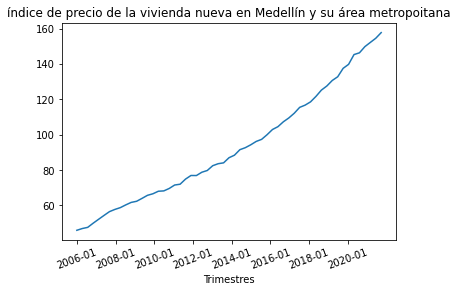

<Figure size 1800x1800 with 0 Axes>

In [ ]:
# Se grafica la serie de tiempo de IPVN
trim = ['2006-01',  '2008-01',  
        '2010-01', '2012-01', 
        '2014-01', '2016-01',
        '2018-01',  '2020-01']

plt.plot(fecha,ipvn)
plt.xticks(np.arange(0, len(fecha), len(fecha)/len(trim)), trim, rotation = 20)
plt.title("índice de precio de la vivienda nueva en Medellín y su área metropoitana")
plt.xlabel("Trimestres") 
plt.figure(figsize=(25,25))

In [ ]:
#Un análisis descriptivo rápido de la serie.
ipvn.describe()

count     57.000000
mean      92.870526
std       32.213213
min       45.940000
25%       66.600000
50%       86.990000
75%      116.740000
max      157.770000
Name: d_IPVN_MDE_Num, dtype: float64

In [ ]:
ipvn=pd.DataFrame(ipvn)

Se tiene un total de 57 registros trimestrales, y la serie no es estacionaria, presentando una tendencia determinística de alta dependencia con los trimestres

In [ ]:
#Se cargan las librerías para correr la red neuronal
import numpy
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Las siguientes líneas se aplicarán con base en: https://unipython.com/prediccion-con-series-temporales-con-lstm-redes-neuronales-recurrentes/

La red que se utilizará es LSTM (redes de memoria larga-corto plazo) a través de la biblioteca Keras. También se conocen como redes neuronales recurrentes

In [ ]:
# Con esta función, se convierte un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)


In [ ]:
# semilla aleatoria para reproducibilidad
numpy.random.seed(7)

In [ ]:
# Se normaliza el conjunto de datos. Nota: El método utilizado para la red neuronal es muy sensible a la escala, especialmente, cuando se utilizan funciones de activación sigmoide, por ende, la serie se debe normalizar.
scaler = MinMaxScaler(feature_range=(0, 1))
ipvn = scaler.fit_transform(ipvn)

In [ ]:
# Se dividen los datos entre entrenamiento y test. Se utiliza un 80% para el entrenamiento y un 20% para la validación
train_size = int(len(ipvn) * 0.8)
test_size = len(ipvn) - train_size

Es importante considerar que, en este tipo de redes neuronales, los datos deben estar de la forma: muestras, pasos de tiempo y características. Por defecto, los datos vienen de la forma, muestras (trimestre) y características (valor del índice). Sin embargo, se le puede agregar el paso del tiempo, tal como se detallará más adelante.

In [ ]:
#Se construye la matriz de datos de entrenamiento y testeo
train, test = ipvn[0:train_size,:], ipvn[train_size:len(ipvn),:]

In [ ]:
#Se pasan a una array
train=np.array(train)
test=np.array(test)

In [ ]:
# Se remodela X=t y Y=t+look_back, con look_back=3.
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
#Se valida cómo quedan organizados los datos
m=pd.DataFrame(trainX)
m.head(10)

,0,1,2
0,0.000000,0.008853,0.014755
1,0.008853,0.014755,0.035769
2,0.014755,0.035769,0.055531
3,0.035769,0.055531,0.075114
4,0.055531,0.075114,0.094250
5,0.075114,0.094250,0.105517
6,0.094250,0.105517,0.114549
7,0.105517,0.114549,0.128409
8,0.114549,0.128409,0.141018
9,0.128409,0.141018,0.146741


In [ ]:
# remodelamos la entrada para que sea muestras, pasos de tiempo, características
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Crearemos la red con una capa visible de 1 entrada, una capa oculta con 8 neuronas y una capa de salida que hace una sola predicción de valor. La función de activación sigmoide por defecto se utiliza para los bloques de memoria LSTM. La red está entrenada para 300 periodos y se utiliza un tamaño de lote de 1.

In [ ]:
#creamos la LSTM network
model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mape', optimizer='Adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
41/41 - 0s - loss: 75.4146
Epoch 2/100
41/41 - 0s - loss: 48.0160
Epoch 3/100
41/41 - 0s - loss: 33.9906
Epoch 4/100
41/41 - 0s - loss: 25.5732
Epoch 5/100
41/41 - 0s - loss: 17.9796
Epoch 6/100
41/41 - 0s - loss: 11.0796
Epoch 7/100
41/41 - 0s - loss: 4.9710
Epoch 8/100
41/41 - 0s - loss: 3.3442
Epoch 9/100
41/41 - 0s - loss: 3.4081
Epoch 10/100
41/41 - 0s - loss: 3.4919
Epoch 11/100
41/41 - 0s - loss: 3.6801
Epoch 12/100
41/41 - 0s - loss: 3.1068
Epoch 13/100
41/41 - 0s - loss: 3.3132
Epoch 14/100
41/41 - 0s - loss: 3.6949
Epoch 15/100
41/41 - 0s - loss: 2.9250
Epoch 16/100
41/41 - 0s - loss: 3.4845
Epoch 17/100
41/41 - 0s - loss: 4.0677
Epoch 18/100
41/41 - 0s - loss: 3.2354
Epoch 19/100
41/41 - 0s - loss: 3.2903
Epoch 20/100
41/41 - 0s - loss: 3.5425
Epoch 21/100
41/41 - 0s - loss: 3.3797
Epoch 22/100
41/41 - 0s - loss: 3.2135
Epoch 23/100
41/41 - 0s - loss: 3.3887
Epoch 24/100
41/41 - 0s - loss: 3.2748
Epoch 25/100
41/41 - 0s - loss: 3.1505
Epoch 26/100
41/41 - 0s - lo

Se observa como la función de pérdida tiende a cero a medida que se van incorporando más iteraciones.

In [ ]:
# Se hacen las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# Se transforman las predicciones para compararla con la variable original de IPVN
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# Se calcula el error cuadrático medio
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore))

Resultado del entrenamiento: 0.73 RMSE


In [ ]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Resultado del test: %.2f RMSE' % (testScore))

Resultado del test: 1.33 RMSE


In [ ]:
testY[0]

array([132.79, 137.56, 139.81, 145.35, 146.34, 149.84, 152.22, 154.57])

In [ ]:
testPredict[:,0]

array([133.195  , 135.78418, 139.0709 , 142.20784, 146.2232 , 149.20844,
       152.27014, 154.53357], dtype=float32)

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
mape(testY[0],testPredict[:,0])

0.6055228242346031

In [ ]:
mape(trainY[0],trainPredict[:,0])

0.7653770212227887

In [ ]:
m=testY[0],testPredict[:,0]
m=pd.DataFrame(m)
m.T

,0,1
0,132.79,133.195007
1,137.56,135.784180
2,139.81,139.070908
3,145.35,142.207840
4,146.34,146.223206
5,149.84,149.208435
6,152.22,152.270142
7,154.57,154.533569


<Figure size 1296x288 with 0 Axes>

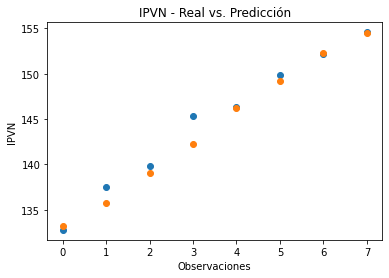

<Figure size 1296x288 with 0 Axes>

In [ ]:
plt.plot(m.T,"o")
plt.title("IPVN - Real vs. Predicción")
plt.xlabel("Observaciones")
plt.ylabel("IPVN")
plt.figure(figsize=(18,4))

In [ ]:
# predicciones del entrenamiento para plotear
trainPredictPlot = numpy.empty_like(ipvn)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [ ]:
# predicciones del test para plotear
testPredictPlot = numpy.empty_like(ipvn)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ipvn)-1, :] = testPredict

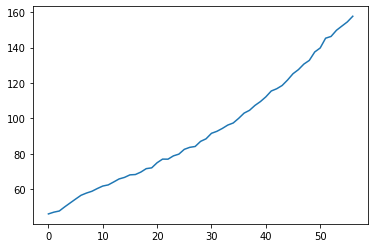

In [ ]:
#Se plotean las predicciones
plt.plot(scaler.inverse_transform(ipvn))

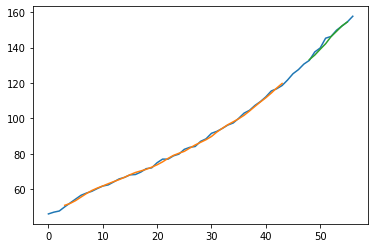

In [ ]:
#Se grafica el ajuste y la predicción

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(ipvn)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(ipvn)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ipvn)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(ipvn))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
# Se guarda el modelo de redes neuronal de mejor MAPE
#model.save('/content/drive/MyDrive/Proyecto Integrador Semestre 2/modelo/modelo0112S.h5')